In [138]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
from torch import nn
from torch.utils.data import dataset
import importlib
import sys
sys.path.append("../")
import ES.ES_classes
import ES.ES_NeuralGraph
importlib.reload(ES.ES_classes)
importlib.reload(ES.ES_NeuralGraph)
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [126]:
batch_size = 256

# Modified from pytorch transformer example


# Top 100 words account for about 50% of speech
vocab_size = 5

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'], max_tokens=vocab_size)
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter):
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# ``train_iter`` was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
n_tokens = train_data.shape[0]
val_data = data_process(val_iter)
test_data = data_process(test_iter)


train_data = train_data[torch.argwhere(train_data != 0)]
val_data = val_data[torch.argwhere(val_data != 0)]
test_data = train_data[torch.argwhere(test_data != 0)]

print(f"Reduction: {100*train_data.shape[0] / n_tokens:.1f}%")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data, batch_size):
    seq_len = data.size(0) // batch_size
    data = data[:seq_len * batch_size]
    data = data.view(batch_size, seq_len).contiguous()
    return data.to(device)

train_data = batchify(train_data, batch_size)  # shape ``[batch_size, seq_len]``
val_data = batchify(val_data, batch_size)
test_data = batchify(test_data, batch_size)

Reduction: 18.2%


In [127]:
# print(train_data.flatten().cpu()[:10].shape)
# _, _, _ = plt.hist(train_data.flatten().cpu()[:10])

In [128]:
bptt = 32
def get_batch(source, i):
    seq_len = min(bptt, source.shape[1] - 1 - i)
    data = source[:, i:i+seq_len]
    target = source[:, i+1:i+1+seq_len]
    return data, target

In [129]:
x_batch, y_batch = get_batch(train_data, 0)

print(x_batch.shape, y_batch.shape)

torch.Size([256, 32]) torch.Size([256, 32])


In [130]:
def itos(tensor): # 1d tensor of indexes to string
    return " ".join(vocab.lookup_tokens(tensor.cpu().numpy().tolist()))

In [131]:
itos(x_batch[0])

', . of the , , . the . , the the . the of , the the the , the of the the . the , of the . the of'

In [132]:
# Shuffles up which tokens map to which indices cuz I'm evil and want to torture the ngraph >:)
def shuffle_lang(x_batch, y_batch):
    reordering = torch.stack([torch.randperm(vocab_size) for _ in range(batch_size)]).to(device)

    x_batch = torch.stack([reordering[i][x_batch[i]] for i in range(batch_size)])
    y_batch = torch.stack([reordering[i][y_batch[i]] for i in range(batch_size)])
    return x_batch, y_batch, reordering

In [133]:
ch_n = 8
ch_e = 8
ch_n_const = 2 # Flag for inp and out node
ch_inp = 1
ch_out = 1

In [134]:
# inp_enc = ES.ES_classes.ES_MLP(nn.Sequential(
#     ES.ES_classes.ES_Linear(ch_n+ch_inp, ch_n-ch_n_const),
# ))

# out_dec = ES.ES_classes.ES_MLP(nn.Sequential(
#     ES.ES_classes.ES_Linear(ch_n, ch_out),
# ))

In [135]:
n_inp = vocab_size
n_hid = 32
n_out = vocab_size

n_nodes = n_inp + n_hid + n_out

connections = [[i, j] for i in range(n_inp) for j in range(n_inp, n_inp + n_hid)] + \
    [[i, j] for i in range(n_inp, n_inp + n_hid) for j in range(n_inp, n_inp + n_hid)] + \
    [[i, j] for i in range(n_inp, n_inp + n_hid) for j in range(n_inp + n_hid, n_inp + n_hid + n_out)]

connections = torch.Tensor(connections)

print(connections.shape)

graph = ES.ES_NeuralGraph.NeuralGraph(n_nodes, n_inp, n_out, connections,
    ch_n=ch_n, ch_e=ch_e, ch_inp=ch_inp, ch_out=ch_out, ch_n_const=2, init_mode="random", init_std=.01, set_nodes=True, use_label=True,
    aggregation="mean", clamp_mode="hard", max_value=100).to(device)# inp_enc=inp_enc, out_dec=out_dec

optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(reduction='none')
sigma = .05

log = []

torch.Size([1344, 2])


In [136]:
const_n=torch.zeros(n_nodes, 2).to(device)
const_n[:n_inp, 0] = 1
const_n[-n_out:, 1] = 1
graph.set_const_vals(const_n)

In [137]:
steps = 100_000
T = 5
DT = 1

with torch.no_grad():

    bar = tqdm(range(1, steps+1))
    for step in bar:
            x_batch, y_batch = get_batch(train_data, torch.randint(train_data.shape[1] - bptt - 1, (1,)))
            shuffled_x, shuffled_y, orderings = shuffle_lang(x_batch, y_batch)

            graph.generate_epsilons(batch_size, sigma=sigma)
            graph.init_vals(nodes=True, edges=True, batch_size=batch_size)

            preds = []
            for t in range(bptt):
                # Unsqueeze to represent only one input node
                pred = graph.forward(nn.functional.one_hot(shuffled_x[:, t], vocab_size), T, DT, edges=False)
                graph.backward(nn.functional.one_hot(shuffled_x[:, t], vocab_size), nn.functional.one_hot(shuffled_y[:, t], vocab_size), T, DT, edges=False, edges_at_end=True)

                preds.append(pred)

            preds = torch.stack(preds, axis=1)
            # For some reason batch dims can be dim 0 and dims 2, 3, ...  NOT DIM 1
            losses = criterion(torch.swapaxes(preds, -1, -2), shuffled_y).mean(-1)
            loss = losses.mean().item()

            accs = (preds.argmax(-1) == shuffled_y).float().mean(-1)
            acc = accs.mean().item()

            overflows = torch.where(graph.nodes.abs() > 5, graph.nodes.abs(), 0).mean(-1).mean(-1) + torch.where(graph.nodes.abs() > 5, graph.nodes.abs(), 0).mean(-1).mean(-1)
            overflow = overflows.mean().item()

            graph.estimate_grads(losses - accs + overflows, sigma=sigma, normalize=True) 
            optimizer.step()

            entry = {'loss':loss, 'acc':acc, 'overflow':overflow}
            log.append(entry)
            bar.set_postfix(entry)

  2%|▏         | 2328/100000 [36:42<25:40:00,  1.06it/s, loss=1.58, acc=0.309, overflow=0.0152]  


KeyboardInterrupt: 

In [30]:
import matplotlib.pyplot as plt

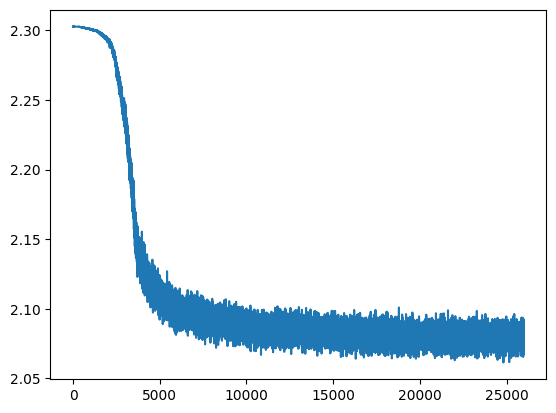

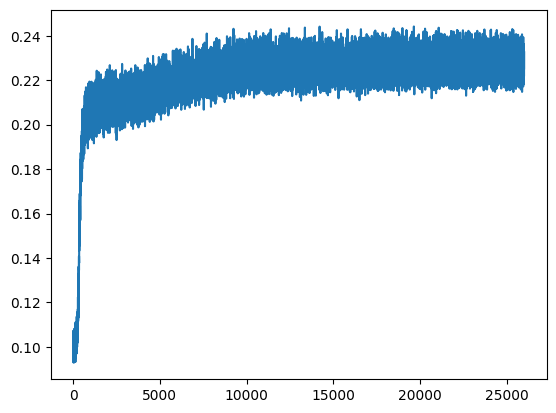

In [31]:
plt.plot([e["loss"] for e in log])
plt.show()
plt.plot([e["acc"] for e in log])
plt.show()

In [40]:
accs = []

with torch.no_grad():
    for _ in range(8):
        x_batch, y_batch = get_batch(train_data, torch.randint(train_data.shape[1] - bptt - 1, (1,)))
        shuffled_x, shuffled_y, orderings = shuffle_lang(x_batch, y_batch)

        graph.generate_epsilons(batch_size, sigma=sigma)
        graph.init_vals(nodes=True, edges=True, batch_size=batch_size)

        preds = []
        for t in range(bptt):
            # Unsqueeze to represent only one input node
            pred = graph.forward(nn.functional.one_hot(shuffled_x[:, t], vocab_size), T, DT, edges=False)
            graph.backward(nn.functional.one_hot(shuffled_x[:, t], vocab_size), nn.functional.one_hot(shuffled_y[:, t], vocab_size), T, DT, edges=False, edges_at_end=True)

            preds.append(pred)

        preds = torch.stack(preds, axis=1)

        accs.append((preds.argmax(-1) == shuffled_y).float().mean(0).cpu().numpy())

In [42]:
import numpy as np

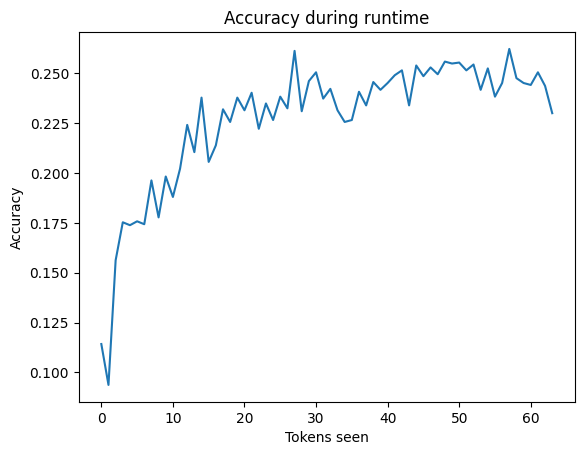

In [59]:
plt.plot(np.mean(np.stack(accs), axis=0))
plt.title("Accuracy during runtime")
plt.xlabel("Tokens seen")
plt.ylabel("Accuracy")
plt.show()

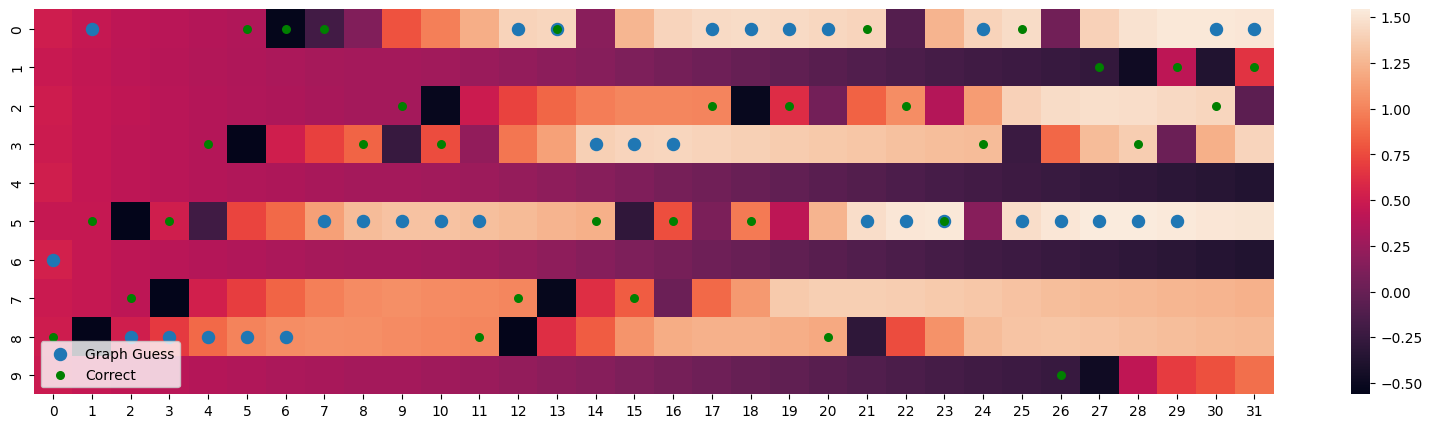

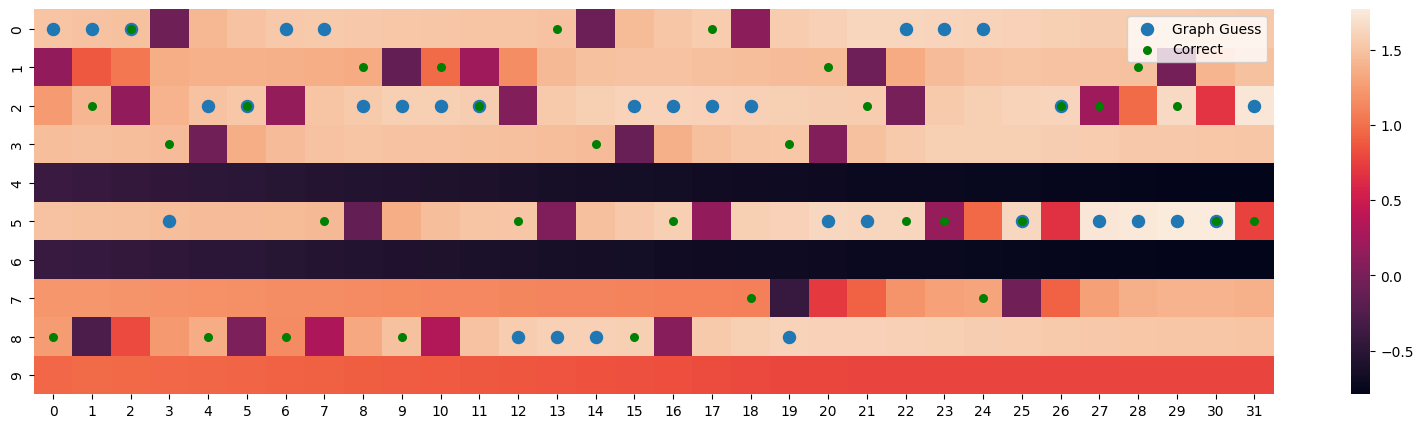

In [82]:
import seaborn as sb

i = 1

plt.figure(figsize=(20, 5))

sb.heatmap(preds[i, :32].cpu().T)

plt.scatter(np.arange(32)+.5, preds[i, :32].argmax(-1).cpu()+.5, s=75, label="Graph Guess")

plt.scatter(np.arange(32)+.5, shuffled_y[i, :32].cpu()+.5, s=30, c="green", label="Correct")

plt.legend()

plt.show()

plt.figure(figsize=(20, 5))

sb.heatmap(preds[i, 32:].cpu().T)

plt.scatter(np.arange(32)+.5, preds[i, 32:].argmax(-1).cpu()+.5, s=75, label="Graph Guess")

plt.scatter(np.arange(32)+.5, shuffled_y[i, 32:].cpu()+.5, s=30, c="green", label="Correct")

plt.legend()

plt.show()

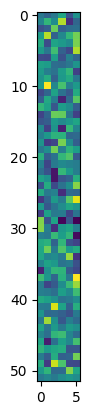

In [67]:
# plt.imshow(graph.init_edges.cpu().detach())
plt.imshow(graph.init_nodes.cpu().detach())

In [47]:
print(graph.init_nodes.shape)
print(graph.const_n.shape)

torch.Size([16, 14])
torch.Size([16, 2])


In [38]:
num_batches = train_data.shape[1] // bptt
print(num_batches)

15


In [37]:
print(train_data.shape)

torch.Size([512, 4003])
